## Install and Import

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import classification_report
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load Dataset


In [6]:
df2 = pd.read_csv("sem18(train+test)and sem22(train with data aug).csv")

this dataset consist of semeval training and test data + sem22 training data with data augmentation

In [7]:
df2

,Unnamed: 0,tweet,sarcastic,clean_headlines
0,0,the biggest only problem thing i got from coll...,1,the biggest only problem thing i got from coll...
1,1,the absolutely only thing i got fired from the...,1,the absolutely only thing i got fired from the...
2,2,perhaps the second only nice thing i got out f...,1,perhaps the second only nice thing i got out f...
3,3,i love it when college professors randomly dra...,1,i love it when college professors randomly dra...
4,4,i really love it funny when professors constan...,1,i really love it funny when professors constan...
...,...,...,...,...
10231,775,"if you drag yesterday into today , your tomorr...",0,"if you drag yesterday into today , your tomorr..."
10232,776,congrats to my fav <user> and her team and my ...,0,congrats to my fav and her team and my birthpl...
10233,777,<user> jessica sheds tears at her fan signing ...,0,jessica sheds tears at her fan signing event m...
10234,778,al jazeera is pro anti <hashtag> gamer gate </...,1,al jazeera is pro anti gamer gate because femi...


In [8]:
df2 = df2[["tweet","sarcastic"]]

In [9]:
df = df2

In [10]:
df.sample(10)

,tweet,sarcastic
1008,oh oh? you're making a totally real gundam ani...,1
2018,@ f geoffreybrock6 @ revrichardcoles where do ...,1
2049,"@ oldunclepunch — yes, because we really have ...",1
10230,this long drive home later in the snow is gonn...,1
2330,fuck why am i really not exactly famous … yet ...,1
7432,<user> i am hurt but i still love you,0
6985,it ' s funny how you can sit for 1 5 minutes a...,1
5667,i hope @NICKIMINAJ is having a great day,0
2418,oh why you guys ’ re just friends? why e ’ n d...,1
3461,do people with clear skin feel accomplished?? ...,1


In [11]:
df["sarcastic"].value_counts()

1    5446
0    4790
Name: sarcastic, dtype: int64

In [12]:
databig1 = pd.read_csv("sarcastic_dataset_13556.csv")
databig1

,tweet,sarcastic,clean_tweet
0,The only thing I got from college is a caffein...,1,thing got college caffeine addiction
1,I love it when professors draw a big question ...,1,love professor draw big question mark next ans...
2,Remember the hundred emails from companies whe...,1,remember hundred email company covid started g...
3,Today my pop-pop told me I was not “forced” to...,1,today pop-pop told “forced” go college 🙃 okay ...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,"too, also reported cancun cruz worrying heartb..."
...,...,...,...
13551,['8-9ft man found in ancient indian burial mou...,0,"8-9ft man found ancient indian burial mound', ..."
13552,"[""Second Scottish independence referendum 'on ...",0,"""second scottish independence referendum 'on t..."
13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0,"pinoy cyborg james simmons', 'mag-ingat sa rid..."
13554,"['The logic here is flawless!', ""No it isn't, ...",0,"the logic flawless!', ""no isn't, one 747 gutte..."


this dataset taken from reedit 

In [13]:

databig1 = databig1.drop(["clean_tweet"],axis=1)
databig1


,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
13551,['8-9ft man found in ancient indian burial mou...,0
13552,"[""Second Scottish independence referendum 'on ...",0
13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
13554,"['The logic here is flawless!', ""No it isn't, ...",0


In [14]:
databig= df.append(databig1)

In [15]:
databig

,tweet,sarcastic
0,the biggest only problem thing i got from coll...,1
1,the absolutely only thing i got fired from the...,1
2,perhaps the second only nice thing i got out f...,1
3,i love it when college professors randomly dra...,1
4,i really love it funny when professors constan...,1
...,...,...
13551,['8-9ft man found in ancient indian burial mou...,0
13552,"[""Second Scottish independence referendum 'on ...",0
13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
13554,"['The logic here is flawless!', ""No it isn't, ...",0


In [16]:
df=databig

In [17]:
df["tweet"].value_counts()

['Day thirteen of three hundred and sixty five . Retired Pope Benedict warns Francis against relaxing priestly celibacy rules CLICK HERE ---> > > <URL> @USER #mmandmp_pro #retweet #rt', "Day thirteen of three hundred and sixty five . Taal volcano : Lava spews as ' hazardous eruption ' feared CLICK HERE ---> > > <URL> @USER #mmandmp_pro #retweet #rt"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               9
['#Who_am_I Born in Japan . After high school , I made my rock band debut . I then founded a fashion EC 

In [18]:
df = df.drop_duplicates(subset=["tweet"])

In [19]:
df["tweet"].value_counts()

the biggest only problem thing i got from college is a strong caffeine heroin addiction                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [20]:
df

,tweet,sarcastic
0,the biggest only problem thing i got from coll...,1
1,the absolutely only thing i got fired from the...,1
2,perhaps the second only nice thing i got out f...,1
3,i love it when college professors randomly dra...,1
4,i really love it funny when professors constan...,1
...,...,...
13551,['8-9ft man found in ancient indian burial mou...,0
13552,"[""Second Scottish independence referendum 'on ...",0
13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
13554,"['The logic here is flawless!', ""No it isn't, ...",0


In [21]:
df.to_csv("sem18(train+test)and sem22(train with data aug)+(13k).csv")

# Data Cleaning

In [22]:
import re
from nltk.corpus import stopwords
import nltk
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


b = list(df["tweet"])
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review) # remove float 
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)

    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
df = df.assign(clean_headlines = corpus)

In [24]:
df

,tweet,sarcastic,clean_headlines
0,the biggest only problem thing i got from coll...,1,the biggest only problem thing i got from coll...
1,the absolutely only thing i got fired from the...,1,the absolutely only thing i got fired from the...
2,perhaps the second only nice thing i got out f...,1,perhaps the second only nice thing i got out f...
3,i love it when college professors randomly dra...,1,i love it when college professors randomly dra...
4,i really love it funny when professors constan...,1,i really love it funny when professors constan...
...,...,...,...
13551,['8-9ft man found in ancient indian burial mou...,0,['8-9ft man found in ancient indian burial mou...
13552,"[""Second Scottish independence referendum 'on ...",0,"[""second scottish independence referendum 'on ..."
13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0,"['pinoy cyborg by james simmons', 'mag-ingat s..."
13554,"['The logic here is flawless!', ""No it isn't, ...",0,"['the logic here is flawless!', ""no it isn't, ..."


# Add special tokens at the beginning and end of each sentence for BERT to work properly 

In [25]:
# Create sentence and label lists
sentences = df.clean_headlines.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.sarcastic.values

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [ ]:
!pip install pytorch-transformers
!pip install transformers

In [27]:
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 918598.77B/s]


Tokenize the first sentence:
['[CLS]', 'the', 'biggest', 'only', 'problem', 'thing', 'i', 'got', 'from', 'college', 'is', 'a', 'strong', 'caf', '##fe', '##ine', 'heroin', 'addiction', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [29]:
# Set the maximum sequence length 
MAX_LEN = 128

In [ ]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [32]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create the attention masks 

In [33]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Split our data into train and validation sets for training

In [34]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors

In [35]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [36]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [37]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:11<00:00, 36759921.68B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning,recommended the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [38]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [39]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [40]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
from sklearn.metrics import classification_report

In [42]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  predictions , true_labels = [], []

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    predictions.append(logits)
    true_labels.append(label_ids)
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()    
    flat_true_labels = [item for sublist in true_labels for item in sublist]
  
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  print(classification_report(flat_true_labels, flat_predictions)) #print classification report after every report 
  

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6167186712498774


Epoch:  33%|███▎      | 1/3 [04:42<09:24, 282.37s/it]

Validation Accuracy: 0.680787037037037
              precision    recall  f1-score   support

           0       0.62      0.87      0.72       963
           1       0.80      0.51      0.62      1036

    accuracy                           0.68      1999
   macro avg       0.71      0.69      0.67      1999
weighted avg       0.72      0.68      0.67      1999

Train loss: 0.46494775544686595


Epoch:  67%|██████▋   | 2/3 [09:23<04:41, 281.79s/it]

Validation Accuracy: 0.7260582010582011
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       963
           1       0.77      0.67      0.72      1036

    accuracy                           0.72      1999
   macro avg       0.73      0.73      0.72      1999
weighted avg       0.73      0.72      0.72      1999

Train loss: 0.2848423983617214


Epoch: 100%|██████████| 3/3 [14:04<00:00, 281.63s/it]

Validation Accuracy: 0.7091931216931217
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       963
           1       0.71      0.75      0.73      1036

    accuracy                           0.71      1999
   macro avg       0.71      0.71      0.71      1999
weighted avg       0.71      0.71      0.71      1999



## Training Evaluation

Let's take a look at our training loss over all batches:

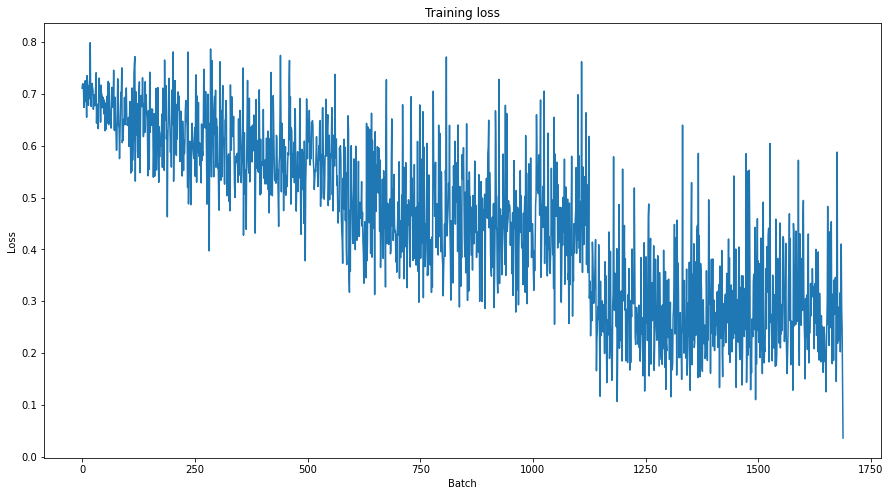

In [43]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate

In [44]:
# out training dataset include this dataset so we can see the evaluation on this dataset and we can see that how perfect our model is trained
df1 = pd.read_csv("train.En.csv")

In [45]:
df1

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()

# all the tweet in a list 
b = list(df1["tweet"]) 

wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []

# data cleaning
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review) #remove float
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
df1 = df1.assign(clean_tweet = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
df1

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,clean_tweet
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0,the only thing i got from college is a caffein...
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0,i love it when professors draw a big question ...
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0,remember the hundred emails from companies whe...
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0,today my pop-pop told me i was not “forced” to...
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0,"i did too, and i also reported cancun cruz not..."
...,...,...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,the population spike in chicago in 9 months is...
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,you'd think in the second to last english clas...
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i’m finally surfacing after a holiday to scotl...
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,couldn't be prouder today. well done to every ...


In [48]:
df1 = df1.drop(["rephrase","sarcasm","irony","satire","understatement","overstatement","rhetorical_question","Unnamed: 0","tweet"],axis=1)

In [49]:
df1

,sarcastic,clean_tweet
0,1,the only thing i got from college is a caffein...
1,1,i love it when professors draw a big question ...
2,1,remember the hundred emails from companies whe...
3,1,today my pop-pop told me i was not “forced” to...
4,1,"i did too, and i also reported cancun cruz not..."
...,...,...
3463,0,the population spike in chicago in 9 months is...
3464,0,you'd think in the second to last english clas...
3465,0,i’m finally surfacing after a holiday to scotl...
3466,0,couldn't be prouder today. well done to every ...


# Create prediction_dataloader for prediction step

In [50]:


# Create sentence and label lists
sentences = df1.clean_tweet.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df1.sarcastic.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [51]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [52]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [54]:
from sklearn.metrics import classification_report

In [55]:
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2601
           1       0.92      0.96      0.94       867

    accuracy                           0.97      3468
   macro avg       0.96      0.97      0.96      3468
weighted avg       0.97      0.97      0.97      3468



so we can see that accuracy of our model on subset of trainig data is 0.96 

In [56]:
from sklearn.metrics import f1_score

In [57]:
f1_score(flat_true_labels, flat_predictions, average='macro')

0.9616792351951327

In [58]:
flat_predictions

array([0, 1, 1, ..., 0, 1, 0])

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(flat_true_labels, flat_predictions)

array([[2533,   68],
       [  33,  834]])

# Prediction on test data (unseen and unlabeled data )

In [60]:
test_data = pd.read_csv("taskA.En.input.csv")

In [61]:
test_data

,text
0,"Size on the the Toulouse team, That pack is mo..."
1,Pinball!
2,So the Scottish Government want people to get ...
3,villainous pro tip : change the device name on...
4,I would date any of these men 🥺
...,...
1395,I’ve just seen this and felt it deserved a Ret...
1396,Omg how an earth is that a pen !!! 🤡
1397,Bringing Kanye and drake to a tl near you
1398,"I love it when women are referred to as ""girl ..."


In [62]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(test_data["text"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
test_data = test_data.assign(clean_text = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


let's assume that label of all tweets is zero 
it does not effect on prediction 

In [63]:
test_data = test_data.assign(random_label=[0 for i in range(len(test_data["clean_text"]))])

In [64]:
test_data

,text,clean_text,random_label
0,"Size on the the Toulouse team, That pack is mo...","size on the the toulouse team, that pack is mo...",0
1,Pinball!,pinball!,0
2,So the Scottish Government want people to get ...,so the scottish government want people to get ...,0
3,villainous pro tip : change the device name on...,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,i would date any of these men 🥺,0
...,...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,i’ve just seen this and felt it deserved a ret...,0
1396,Omg how an earth is that a pen !!! 🤡,omg how an earth is that a pen !!! 🤡,0
1397,Bringing Kanye and drake to a tl near you,bringing kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...","i love it when women are referred to as ""girl ...",0


In [65]:


# Create sentence and label lists
sentences = test_data.clean_text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = test_data.random_label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [66]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [67]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [68]:
flat_predictions

array([0, 0, 1, ..., 0, 1, 0])

In [69]:
test_data = test_data.assign(predicted_label=list(flat_predictions))

In [70]:
test_data

,text,clean_text,random_label,predicted_label
0,"Size on the the Toulouse team, That pack is mo...","size on the the toulouse team, that pack is mo...",0,0
1,Pinball!,pinball!,0,0
2,So the Scottish Government want people to get ...,so the scottish government want people to get ...,0,1
3,villainous pro tip : change the device name on...,villainous pro tip : change the device name on...,0,1
4,I would date any of these men 🥺,i would date any of these men 🥺,0,0
...,...,...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,i’ve just seen this and felt it deserved a ret...,0,0
1396,Omg how an earth is that a pen !!! 🤡,omg how an earth is that a pen !!! 🤡,0,0
1397,Bringing Kanye and drake to a tl near you,bringing kanye and drake to a tl near you,0,0
1398,"I love it when women are referred to as ""girl ...","i love it when women are referred to as ""girl ...",0,1


In [71]:
test_data = test_data.drop(["text","clean_text","random_label"],axis=1)

In [72]:
test_data["predicted_label"].value_counts()

0    922
1    478
Name: predicted_label, dtype: int64

In [73]:
test_data.to_csv("task_a_final.csv")

## Conclusion

This post demonstrate that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Results 

1.F1 socore of  validation data for only sarcastic class is 0.74

In [74]:
test_data = pd.read_csv("task_A_En_test.csv")

In [75]:
test_data = test_data.assign(pred=list(flat_predictions))

In [76]:
test_data

,text,sarcastic,pred
0,"Size on the the Toulouse team, That pack is mo...",0,0
1,Pinball!,0,0
2,So the Scottish Government want people to get ...,1,1
3,villainous pro tip : change the device name on...,0,1
4,I would date any of these men 🥺,0,0
...,...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,0,0
1396,Omg how an earth is that a pen !!! 🤡,0,0
1397,Bringing Kanye and drake to a tl near you,0,0
1398,"I love it when women are referred to as ""girl ...",1,1


In [77]:
confusion_matrix(test_data["sarcastic"], test_data["pred"])

array([[854, 346],
       [ 68, 132]])

In [78]:
print(classification_report(test_data["sarcastic"], test_data["pred"]))

              precision    recall  f1-score   support

           0       0.93      0.71      0.80      1200
           1       0.28      0.66      0.39       200

    accuracy                           0.70      1400
   macro avg       0.60      0.69      0.60      1400
weighted avg       0.83      0.70      0.75      1400

